# **Modules**

In [1]:
from data_preparation.generate_sets import main as generate_sets
from data_preparation.datasets import main as generate_loaders_and_test_nan
from data_preparation.induce_nans import main as generate_test_masked
from data_preparation.preprocessing import preprocess_data

from models.MLP_AE import FullyConnectedAutoencoder
from models.Conv_AE import ConvAutoencoder
from models.LSTM_AE import LSTM_Autoencoder
from models.Transformer_Encoder import make_model

from training.train import train_model

from evaluations.nn_loss import ORT_MIT_Loss
from evaluations.utils import load_model, count_parameters
from evaluations.predict import predict
from evaluations.eval_classical_methods import evaluate_set
from evaluations.mse import evaluate_imputation_mse
from evaluations.t_test import t_test


from sklearn.preprocessing import MinMaxScaler

import torch
import pandas as pd
import configue

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(12, 3))

# configue
config = configue.load("./config.yaml")

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(config["random_state"])

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8vs8u0hp because the default path (/home/fervent_babbage/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Data preprocessing**

In [2]:
generate_sets(config) 

Train, validation and test sets created


In [3]:
train, val, test = preprocess_data(config["path_train"], config["path_val"], config["path_test"], MinMaxScaler(), config["columns_to_drop"])
test_nan, test_mask = generate_test_masked(config,test)

masking done


# **DL models**

## **Train the AutoEncoder**

In [4]:
config_ae = configue.load("./training/config_AE.yaml")
train_loader_ae, val_loader_ae, test_loader_ae = generate_loaders_and_test_nan(config, config_ae,train, val, test, test_nan, test_mask)

total training batch number: 1206
total validation batch number: 298
total test batch number: 10075


In [5]:
loss_fn = ORT_MIT_Loss(config_ae["loss_parameter"])
input_dim = train.shape[1] * config_ae["sequence_length"]
## output dimension
output_dim = input_dim
# Hyperparameters
reduction_parameter = config_ae["reduction_parameter"]
hidden_dim1 = int(input_dim * reduction_parameter)
hidden_dim2 = int(hidden_dim1 * reduction_parameter)
# Init model and loss function
model_ae = FullyConnectedAutoencoder(input_dim, hidden_dim1, hidden_dim2, output_dim)
if torch.cuda.is_available():
    model_ae = model_ae.cuda()

<Axes: xlabel='epochs'>

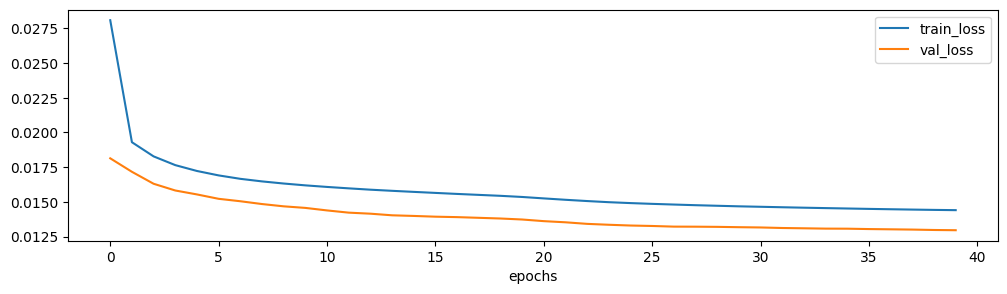

In [6]:
train_loss_list, val_loss_list,model_ae_PATH = train_model(model_ae,loss_fn,config_ae,input_dim,train_loader_ae,val_loader_ae, is_flatten=True, is_TS=False, is_warmed= True)
df = pd.DataFrame({'epochs':[i for i in range(config_ae["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

In [24]:
model_ae_PATH = "./trained_models/AE/model_final_2023-04-06_11:08:55.783890"

## **Train the ConvAE**

In [8]:
config_conv_ae = configue.load("./training/config_convAE.yaml")
train_loader_conv_ae, val_loader_conv_ae, test_loader_conv_ae = generate_loaders_and_test_nan(config, config_conv_ae,train, val, test, test_nan, test_mask)

total training batch number: 1206
total validation batch number: 298
total test batch number: 10075


In [9]:
loss_fn = ORT_MIT_Loss(config_conv_ae["loss_parameter"])
# Parameters
d_input = train.shape[1]
input_dim = train.shape[1] * config_conv_ae["sequence_length"]
# Hyperparameters
reduction_parameter = config_conv_ae["reduction_parameter"]
hidden_dim1 = int(input_dim * reduction_parameter)
hidden_dim2 = int(hidden_dim1 * reduction_parameter)
hidden_dim3 = int(hidden_dim2 * reduction_parameter)
#init model
model_conv_ae = ConvAutoencoder(config_conv_ae["sequence_length"],d_input,hidden_dim1, hidden_dim2,hidden_dim3)
if torch.cuda.is_available():
    model_conv_ae = model_conv_ae.cuda()

<Axes: xlabel='epochs'>

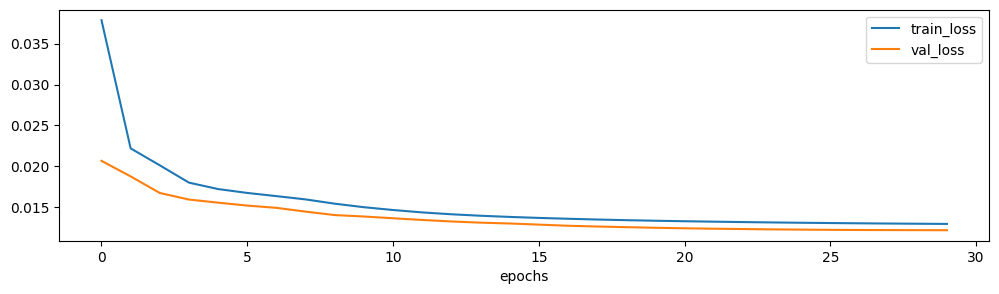

In [10]:
train_loss_list, val_loss_list,model_conv_ae_path = train_model(model_conv_ae,loss_fn,config_conv_ae,input_dim,train_loader_conv_ae,val_loader_conv_ae, is_flatten=False, is_TS=False, is_warmed= False)
df = pd.DataFrame({'epochs':[i for i in range(config_conv_ae["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

In [23]:
model_conv_ae_path = "./trained_models/convAE/model_final_2023-04-06_11:20:22.074493"


## **Train LSTM AE**

In [12]:
config_lstm_ae = configue.load("./training/config_LSTM_AE.yaml")
train_loader_lstm_ae, val_loader_lstm_ae, test_loader_lstm_ae = generate_loaders_and_test_nan(config, config_lstm_ae,train, val, test, test_nan, test_mask)

total training batch number: 1206
total validation batch number: 298
total test batch number: 10075


In [13]:
loss_fn = ORT_MIT_Loss(config_lstm_ae["loss_parameter"])
# Parameters
d_input = train.shape[1]
#Hyperparameters
reduction_parameter = config_lstm_ae["reduction_parameter"]
embedding_size = int(d_input * reduction_parameter)
#init model and loss
model_ae_lstm = LSTM_Autoencoder(config_lstm_ae["sequence_length"],d_input,embedding_size)
if torch.cuda.is_available():
    model_ae_lstm = model_ae_lstm.cuda()


<Axes: xlabel='epochs'>

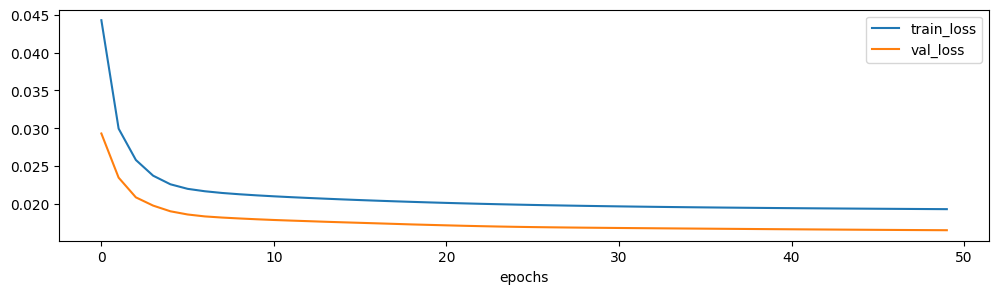

In [14]:
train_loss_list, val_loss_list,model_ae_lstm_path = train_model(model_ae_lstm,loss_fn,config_lstm_ae,d_input,train_loader_lstm_ae,val_loader_lstm_ae, is_flatten=False, is_TS=False, is_warmed= True)
df = pd.DataFrame({'epochs':[i for i in range(config_lstm_ae["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

In [25]:
model_ae_lstm_path = "./trained_models/LSTM_AE/model_final_2023-04-06_11:30:42.495107"

## **Train transformer Encoder**

In [42]:
config_ts = configue.load("./training/config_TS.yaml")
train_loader_ts, val_loader_ts, test_loader_ts = generate_loaders_and_test_nan(config, config_ts,train, val, test, test_nan, test_mask)

total training batch number: 1203
total validation batch number: 294
total test batch number: 10015


In [43]:
loss_fn = ORT_MIT_Loss(config_ts["loss_parameter"])
# Parameters
d_input = train.shape[1]
TS_model = make_model(d_input=d_input, N=config_ts["N"], d_model=config_ts["d_model"], d_ff=config_ts["d_ff"], h=config_ts["h"], dropout=config_ts["dropout"])
if torch.cuda.is_available():
    TS_model = TS_model.cuda()

<Axes: xlabel='epochs'>

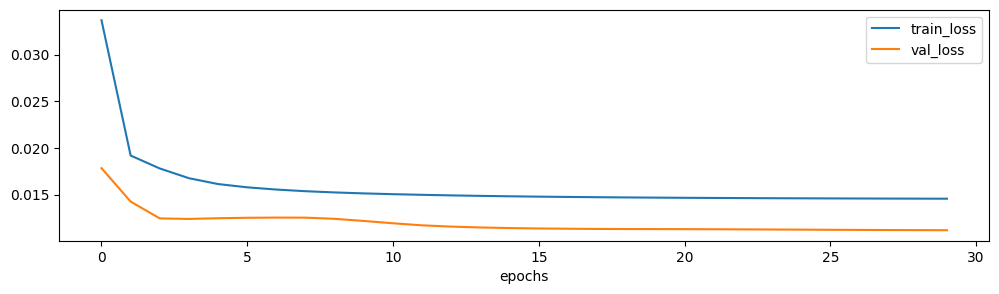

In [44]:
train_loss_list, val_loss_list,TS_model_Path = train_model(TS_model,loss_fn,config_ts,d_input,train_loader_ts,val_loader_ts, is_flatten=False, is_TS=True, is_warmed= False)
df = pd.DataFrame({'epochs':[i for i in range(config_ts["epochs"])],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

In [45]:
print(TS_model_Path)

./trained_models/TS/model_final_2023-04-06_14:58:03.289251


# **Synthesis**

In [26]:
# AE model evaluation
model_ae=load_model(model_ae,model_ae_PATH) #get AE model
test_predicted, test_or = predict(model_ae, test,config_ae["sequence_length"],test_loader_ae, is_flatten = True, is_TS = False )
mse_ae = evaluate_imputation_mse(test_or, test_predicted, test_mask,"AE")
t_test_ae = t_test(test_or, test_predicted, test_mask, "AE")
print("done with ae")

#AE_conv model eval
model_conv_ae=load_model(model_conv_ae,model_conv_ae_path) #get Conv_AE model
test_predicted, test_or = predict(model_conv_ae, test,config_conv_ae["sequence_length"],test_loader_conv_ae, is_flatten = False, is_TS = False )
mse_conv_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"Conv_autoencoder")
t_test_conv_ae = t_test(test_or, test_predicted, test_mask, "Conv_autoencoder")
print("done with convae")

# AE_LSTM model eval
model_ae_lstm=load_model(model_ae_lstm,model_ae_lstm_path) #get LSTM_AE model
test_predicted, test_or = predict(model_ae_lstm, test,config_lstm_ae["sequence_length"],test_loader_lstm_ae, is_flatten = False, is_TS = False )
mse_lstm_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"LSTM_autoencoder")
t_test_lstm_ae = t_test(test_or, test_predicted, test_mask, "LSTM_autoencoder")
print("done with LSTM ae")


Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with ae
Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with convae
Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with LSTM ae


In [27]:
evaluations, tests_classique = evaluate_set(config["class_methods"],test,test_nan,test_mask, config["random_state"])
evaluations=pd.concat([evaluations,mse_lstm_ae,mse_ae,mse_conv_ae],axis=0) #[evaluations,mse_ts,mse_lstm_ae,mse_ae,mse_conv_ae]
evaluations = evaluations.sort_values(by=["mse"])
evaluations.reset_index(drop=True, inplace=True)
evaluations

,method,mse,std
0,Conv_autoencoder,0.013034,0.021413
1,AE,0.016247,0.027973
2,LSTM_autoencoder,0.016538,0.025252
3,linear_interpolation,0.016864,0.027651
4,mice,0.018990,0.033468
5,NOCB,0.028153,0.046744
6,spline_interpolation,0.028379,0.048756
7,mean,0.029201,0.049717
8,LOCF,0.029251,0.048821
9,knn,0.032198,0.057575


In [28]:
count_params = [count_parameters(model) for model in [TS_model,model_ae_lstm,model_ae,model_conv_ae]]
column_model_complexity = pd.DataFrame(count_params, columns=["model_complexity"], index=["Transformer_encoder","LSTM_autoencoder","Autoencoder","Conv_autoencoder"]) 
column_model_complexity.sort_values(by=["model_complexity"])

,model_complexity
LSTM_autoencoder,1037
Autoencoder,11614
Conv_autoencoder,122539
Transformer_encoder,251335


Text(0.5, 1.0, 'MSE evaluation of all approaches in test set')

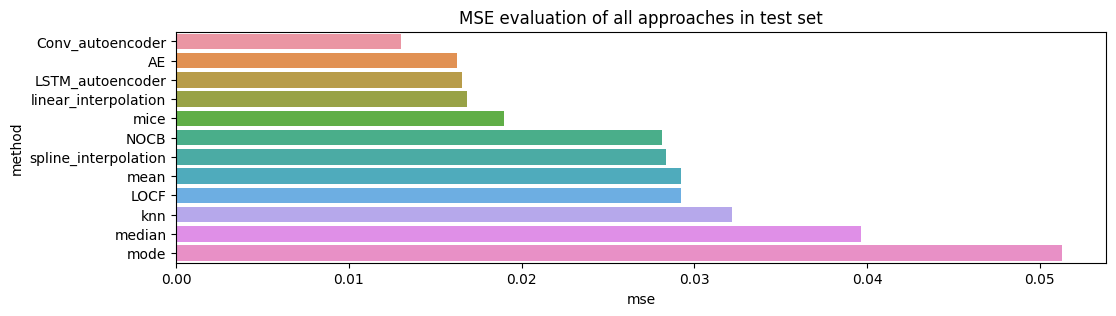

In [29]:
sns.barplot(x='mse',y='method',data=evaluations)
plt.title('MSE evaluation of all approaches in test set')

In [31]:
tests_classique=pd.concat([tests_classique,t_test_ae,t_test_lstm_ae,t_test_conv_ae],axis=0) #t_test_ts
tests_classique

,method,column,p-value,same_distribution
0,mean,Global_active_power,6.843714e-01,False
1,mean,Global_reactive_power,2.538455e-01,False
2,mean,Voltage,2.366918e-01,False
3,mean,Global_intensity,7.415756e-01,False
4,mean,Sub_metering_1,5.597769e-01,False
...,...,...,...,...
2,Conv_autoencoder,Voltage,8.533141e-12,True
3,Conv_autoencoder,Global_intensity,9.182780e-01,False
4,Conv_autoencoder,Sub_metering_1,5.365837e-01,False
5,Conv_autoencoder,Sub_metering_2,6.681557e-01,False


In [32]:
tests_classique["same_distribution"] = tests_classique["same_distribution"].astype(int)
tests_classique.drop(['column','p-value'],axis = 1,inplace=True)
tests_classique = tests_classique.groupby(['method'],as_index=False).sum()
tests_classique = tests_classique.sort_values(by=["same_distribution"],ascending=False)
tests_classique

,method,same_distribution
10,mode,7
0,AE,6
8,median,6
3,LSTM_autoencoder,5
5,knn,5
1,Conv_autoencoder,3
9,mice,1
2,LOCF,0
4,NOCB,0
6,linear_interpolation,0


Text(0.5, 1.0, 'total number of features with same distribution after imputation')

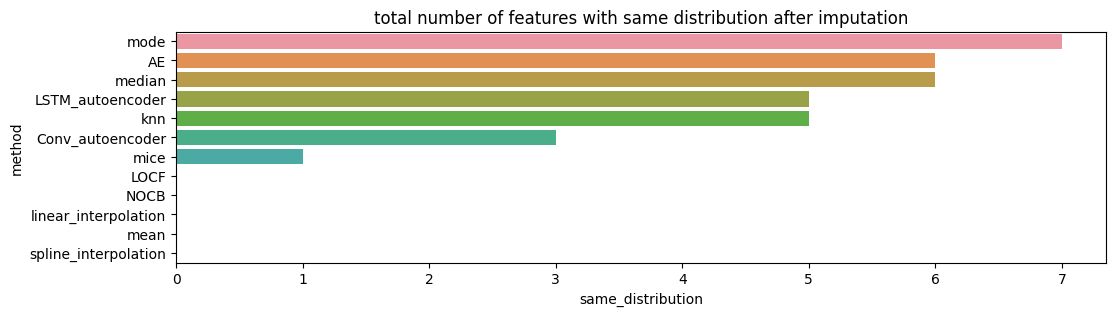

In [33]:
sns.barplot(x='same_distribution',y='method',data=tests_classique)
plt.title("total number of features with same distribution after imputation")

# **Synthese - Mean**

In [35]:
# AE model evaluation
model_ae=load_model(model_ae,model_ae_PATH) #get AE model
test_predicted, test_or = predict(model_ae, test,config_ae["sequence_length"],test_loader_ae, is_flatten = True, is_TS = False, strategy ="mean" )
mse_ae = evaluate_imputation_mse(test_or, test_predicted, test_mask,"AE_mean")
t_test_ae = t_test(test_or, test_predicted, test_mask, "AE_mean")
print("done with ae")

#AE_conv model eval
model_conv_ae=load_model(model_conv_ae,model_conv_ae_path) #get Conv_AE model
test_predicted, test_or = predict(model_conv_ae, test,config_conv_ae["sequence_length"],test_loader_conv_ae, is_flatten = False, is_TS = False, strategy ="mean" )
mse_conv_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"Conv_autoencoder_mean")
t_test_conv_ae = t_test(test_or, test_predicted, test_mask, "Conv_autoencoder_mean")
print("done with convae")

# AE_LSTM model eval
model_ae_lstm=load_model(model_ae_lstm,model_ae_lstm_path) #get LSTM_AE model
test_predicted, test_or = predict(model_ae_lstm, test,config_lstm_ae["sequence_length"],test_loader_lstm_ae, is_flatten = False, is_TS = False, strategy ="mean" )
mse_lstm_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"LSTM_autoencoder_mean")
t_test_lstm_ae = t_test(test_or, test_predicted, test_mask, "LSTM_autoencoder_mean")
print("done with LSTM ae")


Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with ae
Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with convae
Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with LSTM ae


In [36]:
evaluations=pd.concat([evaluations,mse_lstm_ae,mse_ae,mse_conv_ae],axis=0) #[evaluations,mse_ts,mse_lstm_ae,mse_ae,mse_conv_ae]
evaluations = evaluations.sort_values(by=["mse"])
evaluations.reset_index(drop=True, inplace=True)
evaluations

,method,mse,std
0,AE_mean,0.000122,0.000176
1,Conv_autoencoder,0.013034,0.021413
2,AE,0.016247,0.027973
3,LSTM_autoencoder,0.016538,0.025252
4,linear_interpolation,0.016864,0.027651
5,mice,0.018990,0.033468
6,NOCB,0.028153,0.046744
7,spline_interpolation,0.028379,0.048756
8,mean,0.029201,0.049717
9,LOCF,0.029251,0.048821


Text(0.5, 1.0, 'MSE evaluation of all approaches in test set')

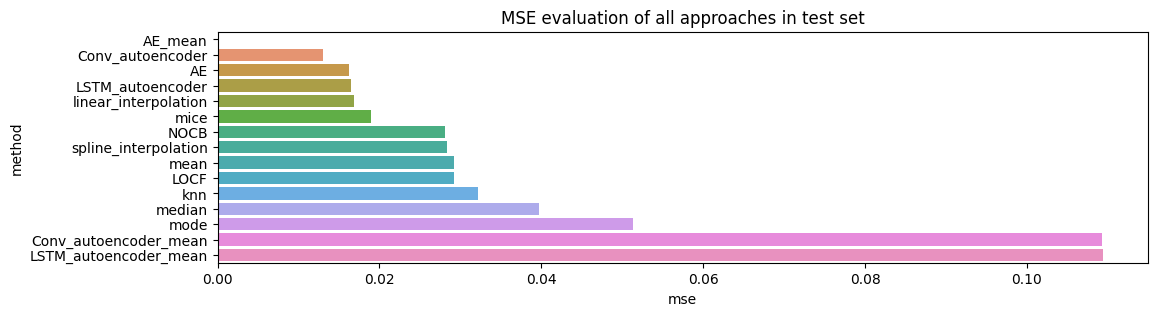

In [37]:
sns.barplot(x='mse',y='method',data=evaluations)
plt.title('MSE evaluation of all approaches in test set')

In [49]:
#transformer model eval
info = torch.load(TS_model_Path)["config_model"]
model_TS = make_model(d_input=d_input, N=info['N'], d_model=info['d_model'], d_ff=info['d_ff'], h=info['h'], dropout=info['dropout'])
model_TS=load_model(model_TS,TS_model_Path) #get LSTM_AE model
if torch.cuda.is_available():
    model_TS = model_TS.cuda()

test_predicted, test_or = predict(model_TS, test,config_ts["sequence_length"],test_loader_ts, is_flatten = False, is_TS = True )
mse_ts = evaluate_imputation_mse(test, test_predicted, test_mask,"Transformer_encoder")
t_test_ts  = t_test(test_or, test_predicted, test_mask, "Transformer_encoder")
print("done with ts")

Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with ts


In [50]:
#transformer model eval
info = torch.load(TS_model_Path)["config_model"]
model_TS = make_model(d_input=d_input, N=info['N'], d_model=info['d_model'], d_ff=info['d_ff'], h=info['h'], dropout=info['dropout'])
model_TS=load_model(model_TS,TS_model_Path) #get LSTM_AE model
if torch.cuda.is_available():
    model_TS = model_TS.cuda()

test_predicted, test_or = predict(model_TS, test,config_ts["sequence_length"],test_loader_ts, is_flatten = False, is_TS = True )
mse_ts_mean = evaluate_imputation_mse(test, test_predicted, test_mask,"Transformer_encoder_mean")
t_test_ts_mean  = t_test(test_or, test_predicted, test_mask, "Transformer_encoder_mean")
print("done with ts")

Prediction loop ...
Prediction loop done
Aggregation ...
Aggregation done
done with ts


In [51]:
evaluations=pd.concat([evaluations,mse_ts_mean,mse_ts],axis=0) #[evaluations,mse_ts,mse_lstm_ae,mse_ae,mse_conv_ae]
evaluations = evaluations.sort_values(by=["mse"])
evaluations.reset_index(drop=True, inplace=True)
evaluations

,method,mse,std
0,AE_mean,0.000122,0.000176
1,Conv_autoencoder,0.013034,0.021413
2,Transformer_encoder_mean,0.015743,0.025408
3,Transformer_encoder,0.015743,0.025408
4,AE,0.016247,0.027973
5,LSTM_autoencoder,0.016538,0.025252
6,linear_interpolation,0.016864,0.027651
7,mice,0.018990,0.033468
8,NOCB,0.028153,0.046744
9,spline_interpolation,0.028379,0.048756


Text(0.5, 1.0, 'MSE evaluation of all approaches in test set')

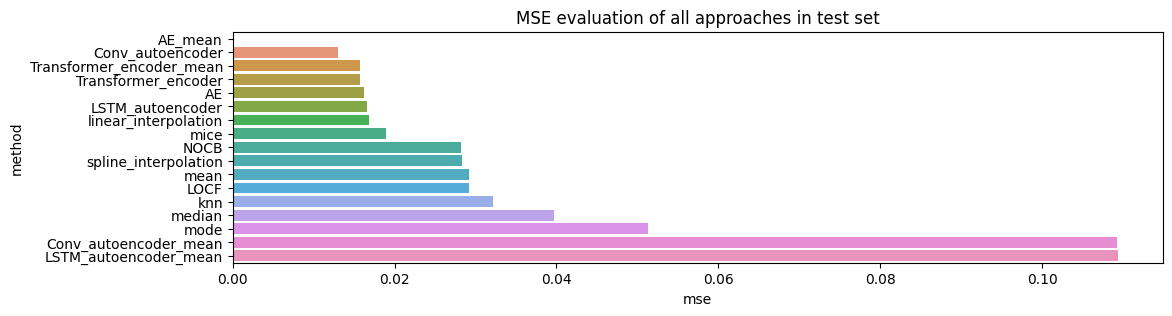

In [52]:
sns.barplot(x='mse',y='method',data=evaluations)
plt.title('MSE evaluation of all approaches in test set')